In [1]:
import matplotlib.pyplot as plt
from matplotlib.container import BarContainer
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict
from os import listdir
import json

from utils.plotting import *

sns.set(style="ticks", font_scale=1.5, font="Liberation Sans")

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8ob0ij04 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Read data

In [116]:
def read_data(folder):
    # Initialize list of dataframes that we will concatenate.
    all_data = []
    
    # Get list of all JSON results files in the folder.
    files_to_read = [f for f in listdir(folder) if f.endswith(".json")]

    # Read each file into a single dataframe.
    for f in files_to_read:
        with open(folder + "/" + f, "r") as fp:
            data = json.load(fp)
        results = pd.DataFrame(data["results"])
        for k, v in data["meta"].items():
            if not isinstance(v, list):
                results[k] = v
        results["corpus"] = f.split("_")[0]
        all_data.append(results)
    df = pd.concat(all_data)
    
    # Rename variables for better-looking figures.
    df["model"] = df.model.apply(pretty_model)
    df["eval_type"] = df.eval_type.apply(pretty_evaltype)
    return df

# Read results for all tasks.
RESULT_DIR = "./results/zh"
TASKS = [
    "exp1_word-prediction",
    # "exp2_word-comparison",
    "exp3a_sentence-judgment",
    "exp3b_sentence-comparison"
]
RESULTS = {
    task.split("_")[0]: read_data(f"{RESULT_DIR}/{task}")
    for task in TASKS
}

# Copy direct data from Experiment 3a to 3b.
_3a = RESULTS["exp3a"].copy()
_3a_direct = _3a[_3a.eval_type=="Direct"]
_3b = RESULTS["exp3b"].copy()
_3b = pd.concat([_3a_direct, _3b])
RESULTS["exp3b"] = _3b

# Figure 2: Task performance (also appendix Figures 4 & 5)

In [117]:
def compute_accuracy_metric(df, task):
    if task == "exp1":
        pass
    
    elif task == "exp2":
        df["model_prefers_good_continuation"] = \
            (df["logprob_of_good_continuation"] > df["logprob_of_bad_continuation"])
    
    elif task == "exp3b":
        def _success_criterion_sentence(row):
            if row.eval_type == "Direct":
                return (row.logprob_of_good_sentence > row.logprob_of_bad_sentence)
            else:
                return (row.logprob_of_good_continuation > row.logprob_of_bad_continuation)
        df["model_prefers_good_sentence"] = df.apply(_success_criterion_sentence, axis=1)
    
    else:
        # Accuracy for "direct"
        df["model_prefers_good_sentence"] = df.apply(
            lambda row: row.logprob_of_good_sentence > row.logprob_of_bad_sentence if row.eval_type == "Direct" else None,
            axis=1
        )
        # True positive
        df["model_prefers_yes_good"] = df.apply(
            lambda row: row.logprob_of_yes_good_sentence > row.logprob_of_no_good_sentence if row.eval_type != "Direct" else None,
            axis=1
        )
        # True negative
        df["model_prefers_no_bad"] = df.apply(
            lambda row: row.logprob_of_no_bad_sentence > row.logprob_of_yes_bad_sentence if row.eval_type != "Direct" else None,
            axis=1
        )
        # False positive
        df["model_prefers_yes_bad"] = df.apply(
            lambda row: row.logprob_of_yes_bad_sentence > row.logprob_of_no_bad_sentence if row.eval_type != "Direct" else None,
            axis=1
        )
        # False negative
        df["model_prefers_no_good"] = df.apply(
            lambda row: row.logprob_of_no_good_sentence > row.logprob_of_yes_good_sentence if row.eval_type != "Direct" else None,
            axis=1
        )
    return df

for task, df in RESULTS.items():
    RESULTS[task] = compute_accuracy_metric(df, task)

## Experiment 1: Word prediction

Rendered figure to zh_exp1_task_performance.png


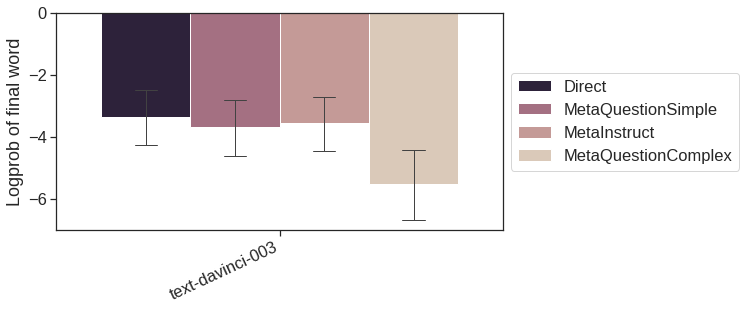

In [130]:
_df = RESULTS["exp1"]
metric = "logprob_of_gold_continuation"
metric_label = "Logprob of final word"
kwargs = dict(
    x="model",
    hue="eval_type",
    xlabel="",
    hue_order=EVAL_TYPES,
    palette=EVAL_TYPE_PAL,
    legend_pos="outside"
)

########################################
# Average over datasets
########################################

ax = plot_metric(_df[_df.model=="text-davinci-003"], metric, ylabel=metric_label, **kwargs)
# ax.get_legend().remove()
plt.gcf().set_size_inches(*BARPLOT_SIZE)
render("zh_exp1_task_performance.png")

plt.show()

## Experiment 3b: Sentence comparison

NOTE: It's simpler to generate the plots for Experiment 3b than the plots for Experiment 3a, so we'll do it first.

In [123]:
_df = RESULTS["exp3b"]
metric = "model_prefers_good_sentence"
_df[_df.eval_type=="Direct"].groupby("model")[metric].mean()
# print(_df[_df.eval_type=="Direct"].logprob_of_good_sentence.mean())
# print(_df[_df.eval_type=="Direct"].logprob_of_bad_sentence.mean())
# _df[_df.eval_type=="Direct"].sort_values(by="logprob_of_bad_sentence")

model
text-davinci-003    0.611215
Name: model_prefers_good_sentence, dtype: float64

Rendered figure to zh_exp3b_task_performance.png


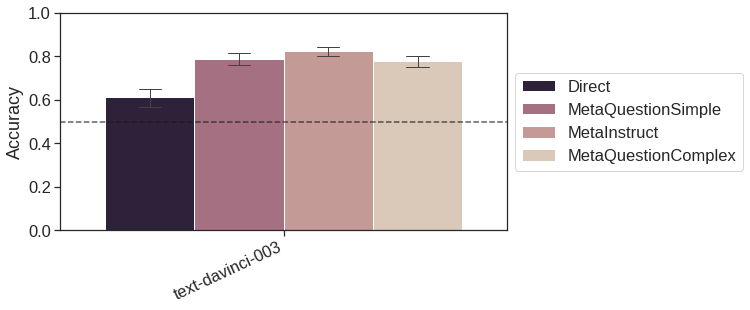

In [129]:
_df = RESULTS["exp3b"]
metric = "model_prefers_good_sentence"
metric_label = "Accuracy"
kwargs = dict(
    x="model",
    hue="eval_type",
    xlabel="",
    hue_order=EVAL_TYPES,
    chance=0.5,
    ylim=(0,1),
    legend_pos="outside"
)

########################################
# Average over datasets
########################################

ax = plot_metric(_df, metric, ylabel=metric_label, **kwargs)
# ax.get_legend().remove()
plt.gcf().set_size_inches(*BARPLOT_SIZE)
render("zh_exp3b_task_performance.png")

plt.show()

## Experiment 3a: Sentence judgment

In [125]:
# Balanced accuracy: (TPR+TNR)/2
def balanced_accuracy(rows):
    tp = rows.model_prefers_yes_good.mean()
    tn = rows.model_prefers_no_bad.mean()
    return np.mean([tp, tn])

# Helper function for getting bootstrapped confidence intervals
# NOTE: this function was adapted from the scipy implementation
def bootstrap_ci(rows, fn, n_resamples=1000, confidence_level=0.95):
    stat_dist = []
    
    # Resample the data: random sample of the original sample (with replacement) of the same size as the original sample.
    for _ in range(n_resamples):
        sample = rows.sample(frac=1, replace=True)

    # Compute the bootstrap distribution of the statistic: for each set of resamples, compute the test statistic.
        test_stat = balanced_accuracy(sample)
        stat_dist.append(test_stat)

    # Determine the confidence interval.

    # Calculate percentile interval
    alpha = (1 - confidence_level)/2
    interval = alpha, 1-alpha

    def percentile_fun(a, q):
        return np.percentile(a=a, q=q, axis=-1)

    # Calculate confidence interval of statistic
    ci_l = percentile_fun(stat_dist, interval[0]*100)
    ci_u = percentile_fun(stat_dist, interval[1]*100)
    return ci_l, ci_u

# Wrapper function for getting CIs
def balanced_accuracy_ci(df):
    res = []
    for model in df.model.unique():
        for eval_type in META_EVAL_TYPES:
            # Get relevant rows.
            rows = df[(df.model==model)&(df.eval_type==eval_type)]

            # Bootstrap 95% CI.
            print(f"Bootstrapping CI for {model}, {eval_type}...")
            ci_l, ci_u = bootstrap_ci(rows, balanced_accuracy)

            # Compute accuracy.
            res.append(dict(
                model=model,
                eval_type=eval_type,
                accuracy=balanced_accuracy(rows),
                ci_low=ci_l,
                ci_high=ci_u
            ))
    acc = pd.DataFrame(res)
            
    return acc

# Compute accuracy and CIs
def get_accuracy_data_3a(df):
    # Get accuracy and CIs for metalinguistic methods.
    acc = balanced_accuracy_ci(df)
    
    # Compute accuracy for direct condition.
    direct_acc = []
    for corpus in df.corpus.unique():
        for model in acc.model.unique():
            rows = df[(df.model==model)&(df.eval_type=="Direct")&(df.corpus==corpus)]
            for item_id in rows.item_id.unique():
                direct_acc.append(dict(
                    model=model,
                    eval_type="Direct",
                    corpus=corpus,
                    accuracy=int(rows[rows.item_id==item_id].squeeze().model_prefers_good_sentence)
                ))
    direct_acc = pd.DataFrame(direct_acc)
    full_acc = pd.concat([direct_acc, acc])
    return full_acc

In [126]:
_df = RESULTS["exp3a"]
_acc = get_accuracy_data_3a(_df)

Bootstrapping CI for text-davinci-003, MetaQuestionSimple...
Bootstrapping CI for text-davinci-003, MetaInstruct...
Bootstrapping CI for text-davinci-003, MetaQuestionComplex...


Rendered figure to zh_exp3a_task_performance.png


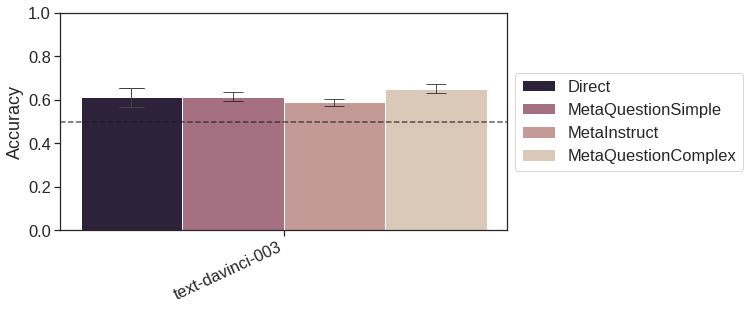

In [135]:
metric = "accuracy"
metric_label = "Accuracy"
kwargs = dict(
    x="model",
    hue="eval_type",
    xlabel="",
    hue_order=EVAL_TYPES,
    chance=0.5,
    ylim=(0,1),
    legend_pos="outside"
)

def add_metalinguistic_errorbars(ax, acc_df):
    model_order = [m for m in GLOBAL_MODEL_ORDER if m in acc_df.model.unique()]
    # Add custom error bars for metalinguistic conditions
    for eval_type_idx, container in enumerate(ax.containers):
        if isinstance(container, BarContainer):
            eval_type = EVAL_TYPES[eval_type_idx]

            # We don't need to manually add error bars for Direct method.
            if eval_type != "Direct":
                for model_idx, bar in enumerate(container.get_children()):
                    model = model_order[model_idx]
                    row = acc_df[(acc_df.eval_type==eval_type)&(acc_df.model==model)].squeeze()
                    ci_l = row.ci_low
                    ci_u = row.ci_high
                    ax.errorbar(
                        bar.get_x()+bar.get_width()/2, 
                        bar.get_height(), 
                        yerr=(ci_u - bar.get_height()), 
                        capsize=10, elinewidth=1,
                        color="k",
                        alpha=0.75
                    )
    # manually adjust x-axis limits, which get shifted by errorbar plotting
    # ax.set_xlim(-0.5, 5.5)
    return ax

########################################
# Average over datasets
########################################

ax = plot_metric(_acc, metric, ylabel=metric_label, **kwargs)
# ax.get_legend().remove()
ax = add_metalinguistic_errorbars(ax, _acc)
plt.gcf().set_size_inches(*BARPLOT_SIZE)
render("zh_exp3a_task_performance.png")
plt.show()

# Internal consistency

In [10]:
# Initialize all correlation data
ALL_CORRS = defaultdict(dict)

p18
Rendered figure to scatter_exp1_hf_p18.pdf


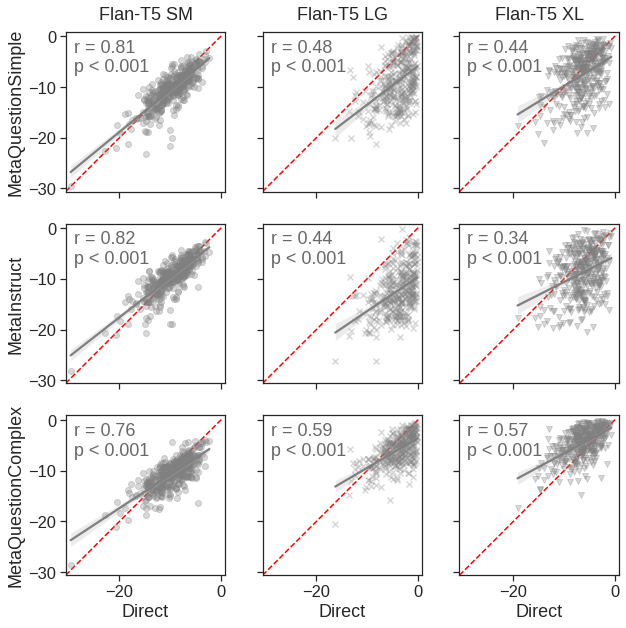

Rendered figure to scatter_exp1_openai_p18.pdf


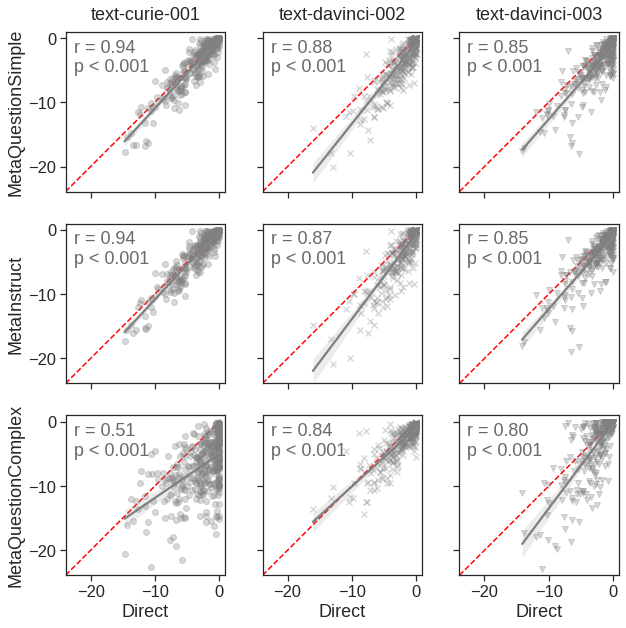

news
Rendered figure to scatter_exp1_hf_news.pdf


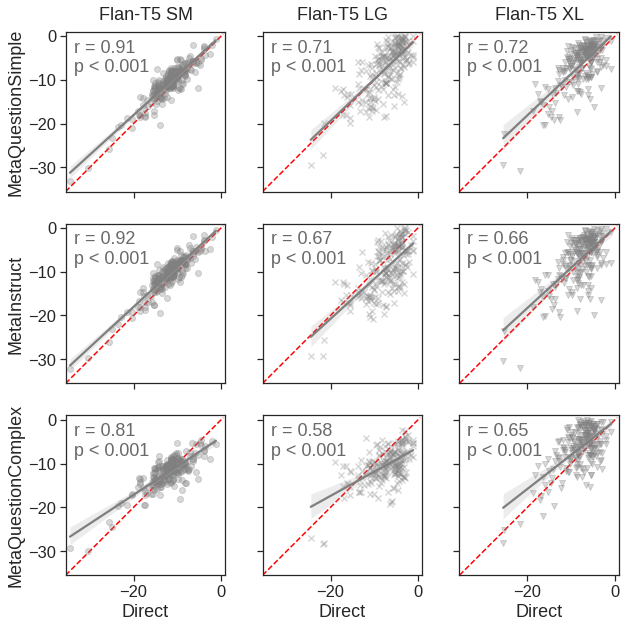

Rendered figure to scatter_exp1_openai_news.pdf


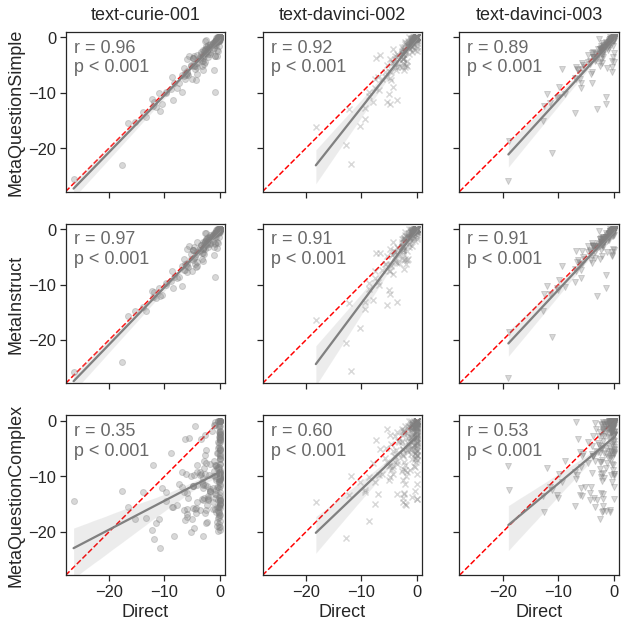

In [11]:
def plot_corrs_exp1(df, model_list):
    fig, axes = plt.subplots(
        nrows=len(META_EVAL_TYPES), ncols=len(model_list), sharex=True, sharey=True, figsize=(10,10)
    )
    MARKERS = ["o", "x", "v", "+", "d", "p", "^"]
    
    # Determine min and max values for given models, so the same axis scales can be applied to the whole figure.
    scale_min = df[df.model.isin(model_list)].logprob_of_gold_continuation.min()
    scale_max = df[df.model.isin(model_list)].logprob_of_gold_continuation.max()
    vals = np.arange(scale_min-1, scale_max+1)
    
    corr_matrix = np.zeros((len(META_EVAL_TYPES), len(model_list)))
    for i, eval_type in enumerate(META_EVAL_TYPES):
        for j, model in enumerate(model_list):
            if len(model_list) == 1:
                ax = axes[i]
            else:
                ax = axes[i][j]

            try:
                xs = df[(df.model==model)&(df.eval_type=="Direct")].sort_values(by="item_id").logprob_of_gold_continuation
                ys = df[(df.model==model)&(df.eval_type==eval_type)].sort_values(by="item_id").logprob_of_gold_continuation
                corr = report_corr(xs, ys).set_index("method")
                r, p = corr.loc["pearson"][["r", "p"]]
                corr_matrix[i][j] = r

                ax = sns.regplot(
                    x=xs, y=ys, color="grey", marker=MARKERS[j], ax=ax, scatter_kws={"alpha":0.3},
                )
                ax.set_aspect('equal')
                
                # Same scales on both axes.
                ax.set_xlim(scale_min-1, scale_max+1)
                ax.set_ylim(scale_min-1, scale_max+1)
                
                # Add x=y line
                ax.plot(vals, vals, linestyle="--", color="red", zorder=0)

                if i == len(direct_pairs)-1:
                    ax.set_xlabel("Direct")
                else:
                    # ax.set_xticklabels([])
                    ax.set_xlabel("")
                    if i == 0:
                        ax.set_title(model, pad=12)
                if j == 0:
                    ax.set_ylabel(eval_type)
                else:
                    ax.set_ylabel("")

                p_str = "p < 0.001" if p < 0.001 else f"p = {p:.3f}"
                ax.text(0.05, 0.75, f"r = {r:.2f}\n{p_str}", transform=ax.transAxes, color="dimgrey")


            except:
                continue
    return corr_matrix

###############################################################################
# Get correlations for Experiment 1
###############################################################################
task = "exp1"
_df = RESULTS[task]
for corpus in _df.corpus.unique():
    print(corpus)
    hf_corrs = plot_corrs_exp1(_df[_df.corpus==corpus], HF_MODELS)
    render(f"scatter_{task}_hf_{corpus}.pdf")
    plt.show()
    openai_corrs = plot_corrs_exp1(_df[_df.corpus==corpus], OPENAI_MODELS)
    render(f"scatter_{task}_openai_{corpus}.pdf")
    plt.show()
    ALL_CORRS[task][corpus] = {
        "hf": hf_corrs,
        "openai": openai_corrs
    }

Rendered figure to scatter_exp2_hf.pdf


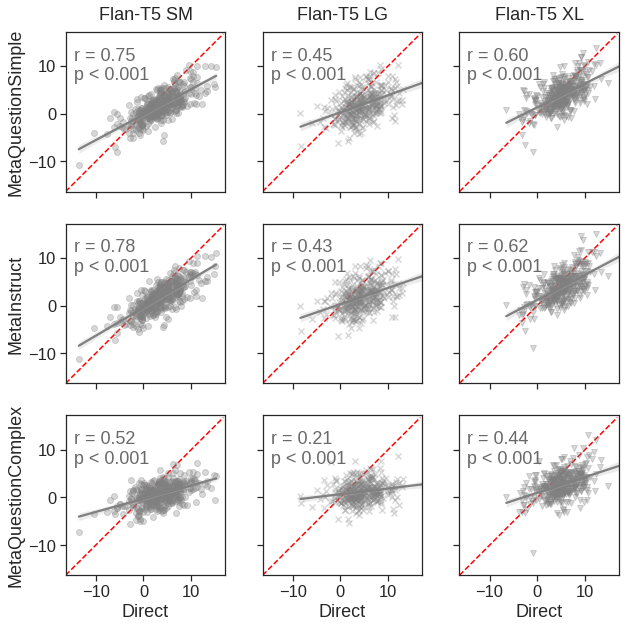

Rendered figure to scatter_exp2_openai.pdf


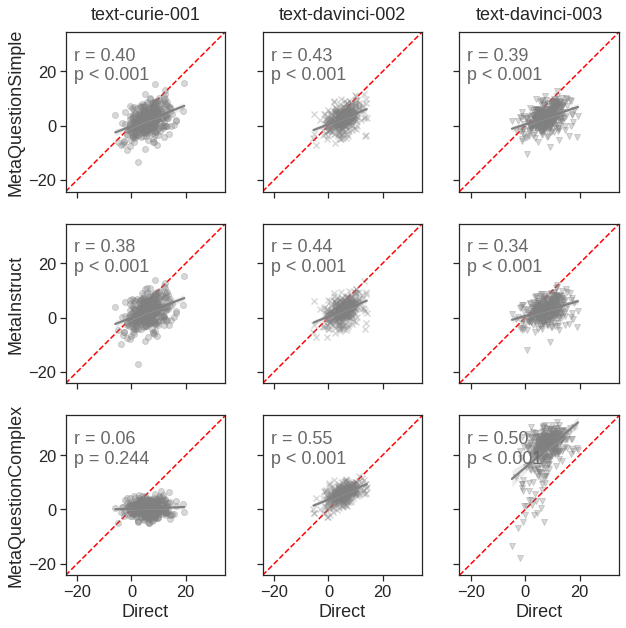

In [12]:
# Compute differentials (logp(good|prefix) - logp(bad|prefix)).
def _compute_diffs_exp2(df):
    g = df.set_index(["item_id", "model", "eval_type", "option_order"])
    new_data = []
    for item_id in sorted(df.item_id.unique()):
        for model in HF_MODELS + OPENAI_MODELS:
            try:
                # We only have good_first for the direct measurement (since the answers are not actually presented)
                direct_row = g.loc[item_id, model, "Direct", "goodFirst"] 
                for option_order in OPTION_ORDERS:
                    for eval_type in META_EVAL_TYPES:
                        # Get relevant row.
                        prompt_row = g.loc[item_id, model, eval_type, option_order]

                        # Does the preferred continuation match across the direct and metaprompt methods?
                        agree = (direct_row.model_prefers_good_continuation == prompt_row.model_prefers_good_continuation)

                        # Difference in log probabilities (positive difference = correct)
                        direct_differential = (direct_row.logprob_of_good_continuation - direct_row.logprob_of_bad_continuation)
                        prompt_differential = (prompt_row.logprob_of_good_continuation - prompt_row.logprob_of_bad_continuation)
                        
                        # Record data
                        new_data.append(dict(
                            item_id=item_id,
                            model=model,
                            direct_prompt_agree=agree,
                            direct_differential=direct_differential,
                            prompt_differential=prompt_differential,
                            eval_type=eval_type,
                            option_order=option_order
                        ))
            except:
                continue
    agreement = pd.DataFrame(new_data)
    return agreement

def plot_corrs_exp2(df, model_list):
    fig, axes = plt.subplots(nrows=len(direct_pairs), ncols=len(model_list), sharex=True, sharey=True, figsize=(10, 10))
    MARKERS = ["o", "x", "v", "+", "d", "p", "^"]
    
    # Determine min and max values for given models, so the same axis scales can be applied to the whole figure.
    scale_min = df[df.model.isin(model_list)].prompt_differential.min()
    scale_max = df[df.model.isin(model_list)].prompt_differential.max()
    vals = np.arange(scale_min-1, scale_max+1)

    corr_matrix = np.zeros((len(META_EVAL_TYPES), len(model_list)))
    for i, eval_type in enumerate(META_EVAL_TYPES):
        for j, model in enumerate(model_list):
            if len(model_list) == 1:
                ax = axes[i]
            else:
                ax = axes[i][j]

            try:
                sub_df = df[(df.model==model)&(df.eval_type==eval_type)]
                
                # Take average over option orders (goodFirst, or badFirst).
                good_first = sub_df[sub_df.option_order=="goodFirst"].sort_values(by="item_id")
                bad_first = sub_df[sub_df.option_order=="badFirst"].sort_values(by="item_id")                
                xs = good_first.direct_differential
                ys = np.mean(np.array([good_first.prompt_differential, bad_first.prompt_differential]), axis=0)
                
                # Record correlations.
                corr = report_corr(xs, ys).set_index("method")
                r, p = corr.loc["pearson"][["r", "p"]]
                corr_matrix[i][j] = r

                ax = sns.regplot(
                    x=xs, y=ys, color="grey", marker=MARKERS[j], ax=ax, scatter_kws={"alpha":0.3}
                )
                ax.set_aspect('equal')
                
                # Same scales on both axes.
                ax.set_xlim(scale_min-1, scale_max+1)
                ax.set_ylim(scale_min-1, scale_max+1)
                
                # Add x=y line
                ax.plot(vals, vals, linestyle="--", color="red", zorder=0)

                if i == len(direct_pairs)-1:
                    # pass
                    ax.set_xlabel("Direct")
                else:
                    # ax.set_xticklabels([])
                    ax.set_xlabel("")
                    if i == 0:
                        ax.set_title(model, pad=12)
                if j == 0:
                    ax.set_ylabel(eval_type)
                else:
                    ax.set_ylabel("")

                p_str = "p < 0.001" if p < 0.001 else f"p = {p:.3f}"
                ax.text(0.05, 0.7, f"r = {r:.2f}\n{p_str}", transform=ax.transAxes, color="dimgrey")

            except:
                continue
    return corr_matrix

###############################################################################
# Get correlations for Experiment 2
###############################################################################
task = "exp2"
_df = _compute_diffs_exp2(RESULTS[task])

hf_corrs = plot_corrs_exp2(_df, HF_MODELS)
render(f"scatter_{task}_hf.pdf")
plt.show()

openai_corrs = plot_corrs_exp2(_df, OPENAI_MODELS)
render(f"scatter_{task}_openai.pdf")
plt.show()

ALL_CORRS[task] = {
    "hf": hf_corrs,
    "openai": openai_corrs
}

syntaxgym
Rendered figure to scatter_exp3a_hf_syntaxgym.pdf


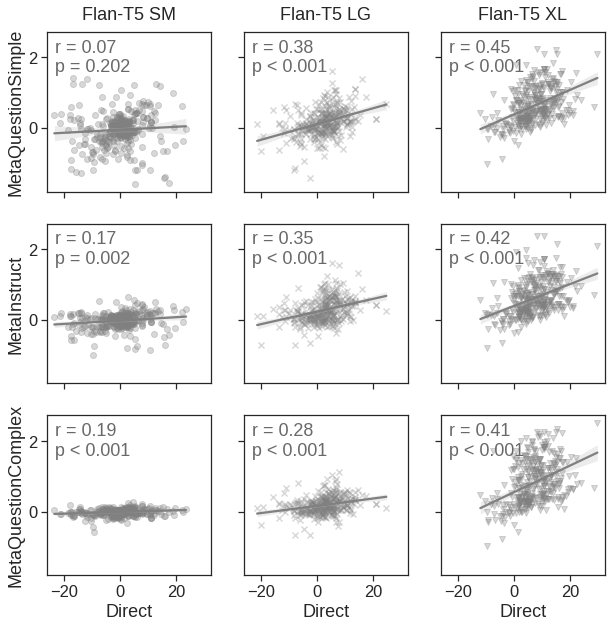

Rendered figure to scatter_exp3a_openai_syntaxgym.pdf


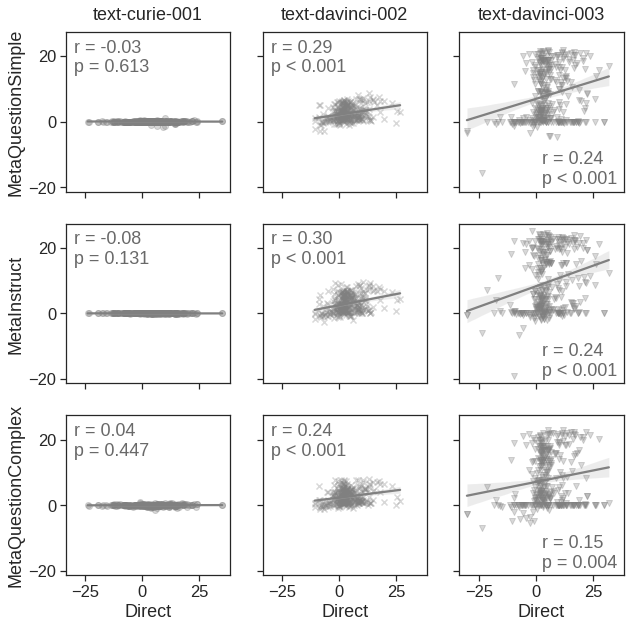

blimp
Rendered figure to scatter_exp3a_hf_blimp.pdf


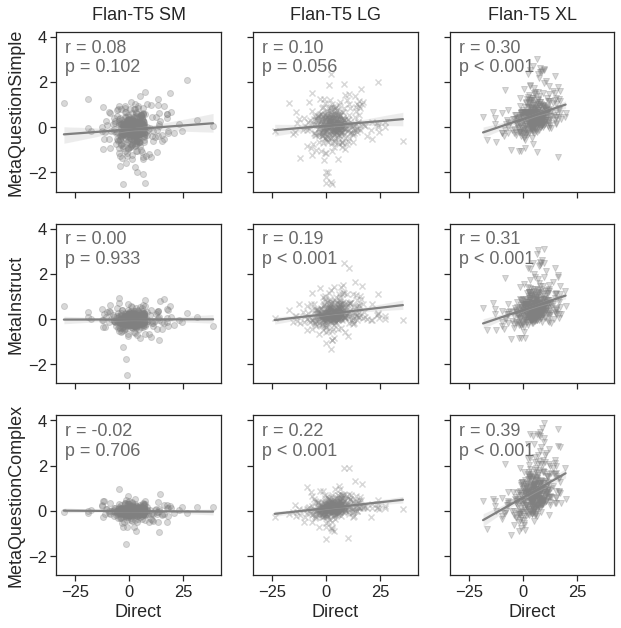

Rendered figure to scatter_exp3a_openai_blimp.pdf


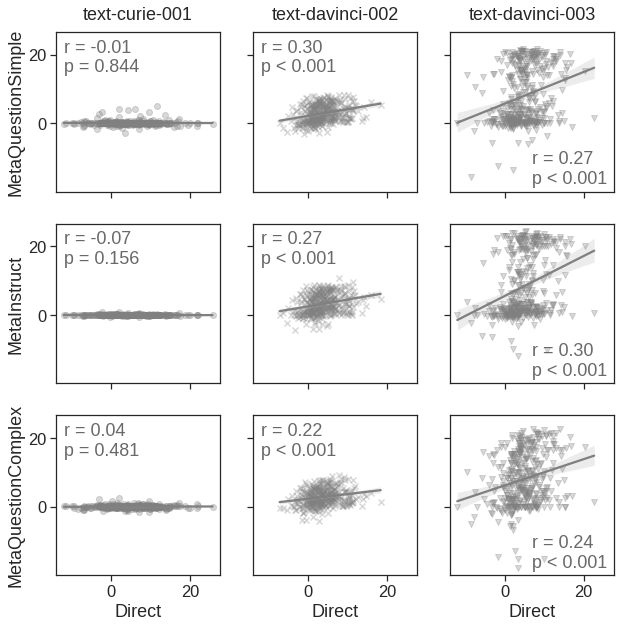

In [13]:
def _compute_diffs_exp3a(df):
    # Compute differentials.
    g = df.set_index(["item_id", "model", "eval_type"])
    new_data = []
    for item_id in sorted(df.item_id.unique()):
        for model in HF_MODELS + OPENAI_MODELS:
            # We only have good_first for the direct measurement (since the answers are not actually presented)
            direct_row = g.loc[item_id, model, "Direct"] 
            for eval_type in META_EVAL_TYPES:
                # Get relevant row.
                prompt_row = g.loc[item_id, model, eval_type]

                # Does the preferred continuation match across the direct and metaprompt methods?
                # prompt_corect = (prompt_row.logprob_of_yes_good_sentence > prompt_row.logprob_of_yes_bad_sentence)
                # agree = (direct_row.model_prefers_good_sentence == prompt_correct)

                # Difference in log probabilities (positive difference = correct)
                direct_differential = (direct_row.logprob_of_good_sentence - direct_row.logprob_of_bad_sentence)
                prompt_differential = (prompt_row.logprob_of_yes_good_sentence - prompt_row.logprob_of_yes_bad_sentence)

                # Record data
                new_data.append(dict(
                    item_id=item_id,
                    model=model,
                    # direct_prompt_agree=agree,
                    direct_differential=direct_differential,
                    prompt_differential=prompt_differential,
                    eval_type=eval_type,
                ))

    agreement = pd.DataFrame(new_data)
    return agreement
    
def plot_corrs_exp3a(df, model_list):
    fig, axes = plt.subplots(
        nrows=len(direct_pairs), ncols=len(model_list), sharex=True, sharey=True, figsize=(10, 10)
    )
    MARKERS = ["o", "x", "v", "+", "d", "p", "^"]

    corr_matrix = np.zeros((len(META_EVAL_TYPES), len(model_list)))
    for i, eval_type in enumerate(META_EVAL_TYPES):
        for j, model in enumerate(model_list):
            if len(model_list) == 1:
                ax = axes[i]
            else:
                ax = axes[i][j]

            try:
                # There are no option orders for this task.
                sub_df = df[(df.model==model)&(df.eval_type==eval_type)].sort_values(by="item_id")              
                xs = sub_df.direct_differential
                ys = sub_df.prompt_differential
                
                # Record correlations.
                corr = report_corr(xs, ys).set_index("method")
                r, p = corr.loc["pearson"][["r", "p"]]
                corr_matrix[i][j] = r

                ax = sns.regplot(
                    x=xs, y=ys, color="grey", marker=MARKERS[j], ax=ax, scatter_kws={"alpha":0.3}
                )
                # ax.set_aspect('equal')

                if i == len(direct_pairs)-1:
                    ax.set_xlabel("Direct")
                else:
                    # ax.set_xticklabels([])
                    ax.set_xlabel("")
                    if i == 0:
                        ax.set_title(model, pad=12)
                if j == 0:
                    ax.set_ylabel(eval_type)
                else:
                    ax.set_ylabel("")

                p_str = "p < 0.001" if p < 0.001 else f"p = {p:.3f}"
                if model == "text-davinci-003":
                    xcoord = 0.5
                    ycoord = 0.05
                else:
                    xcoord = 0.05
                    ycoord = 0.75
                ax.text(xcoord, ycoord, f"r = {r:.2f}\n{p_str}", transform=ax.transAxes, color="dimgrey")

            except:
                continue
    return corr_matrix

###############################################################################
# Get correlations for Experiment 3a
###############################################################################
task = "exp3a"
_df = RESULTS[task]
for corpus in _df.corpus.unique():
    print(corpus)
    _corpus_df = _df[_df.corpus==corpus]
    _diffs_df = _compute_diffs_exp3a(_corpus_df)
    hf_corrs = plot_corrs_exp3a(_diffs_df, HF_MODELS)
    render(f"scatter_{task}_hf_{corpus}.pdf")
    plt.show()
    openai_corrs = plot_corrs_exp3a(_diffs_df, OPENAI_MODELS)
    render(f"scatter_{task}_openai_{corpus}.pdf")
    plt.show()
    ALL_CORRS[task][corpus] = {
        "hf": hf_corrs,
        "openai": openai_corrs
    }

syntaxgym
Rendered figure to scatter_exp3b_hf_syntaxgym.pdf


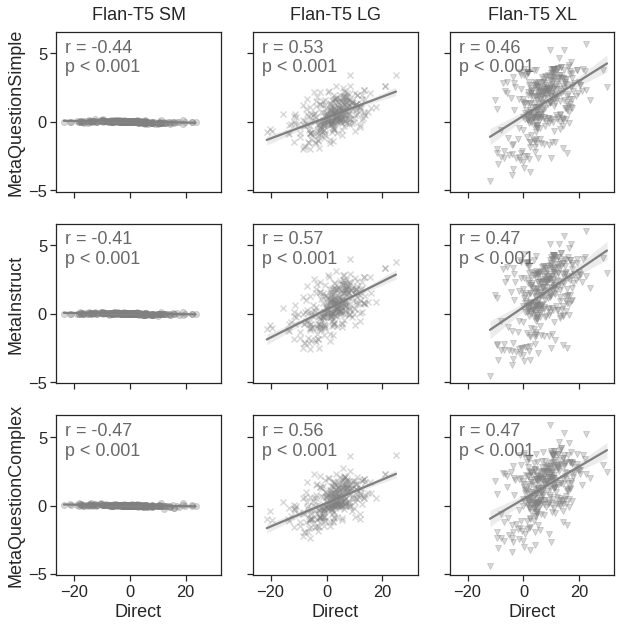

Rendered figure to scatter_exp3b_openai_syntaxgym.pdf


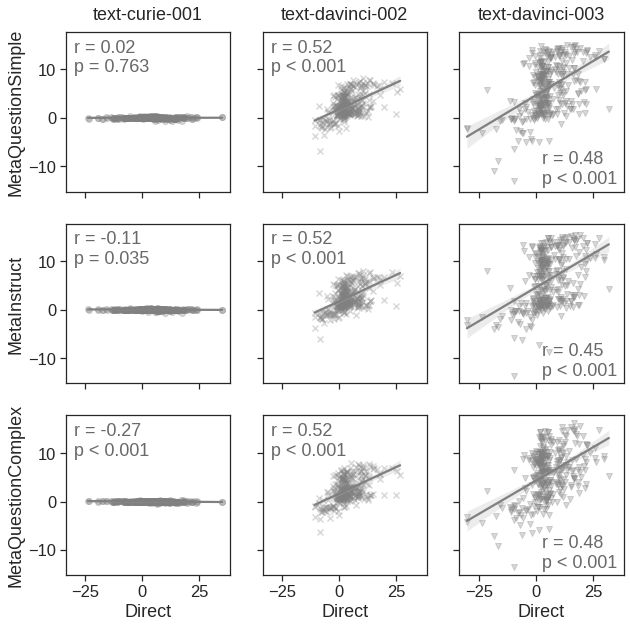

blimp
Rendered figure to scatter_exp3b_hf_blimp.pdf


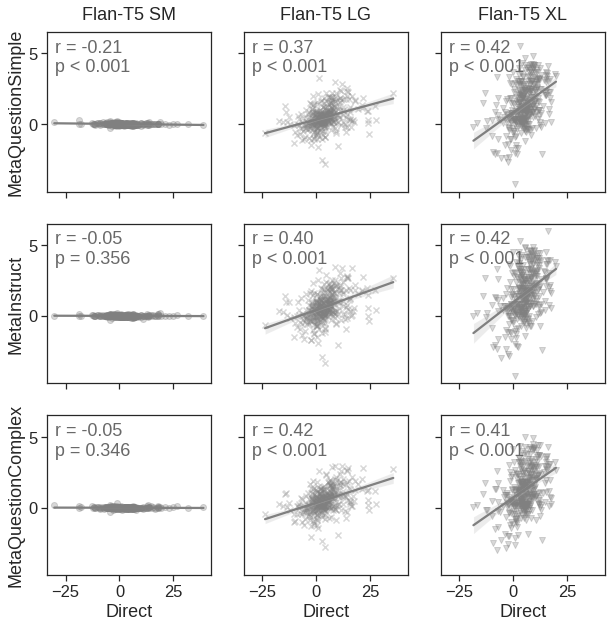

Rendered figure to scatter_exp3b_openai_blimp.pdf


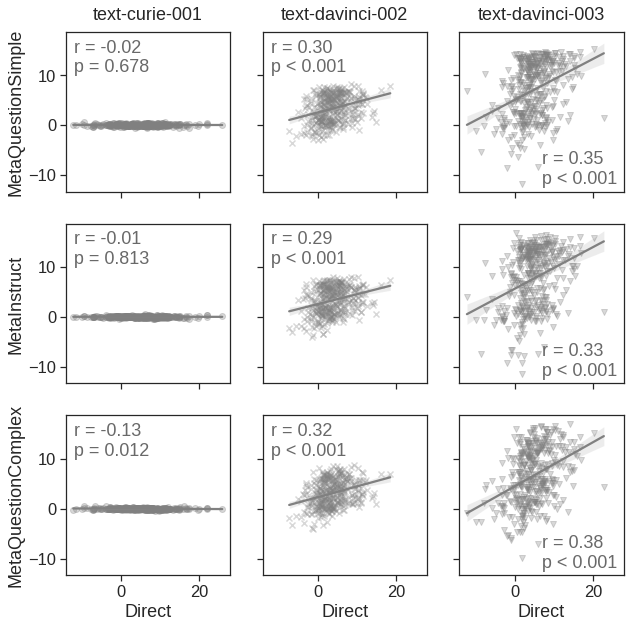

In [14]:
def _compute_diffs_exp3b(df):
    # Compute differentials.
    g = df.set_index(["item_id", "model", "eval_type", "option_order"])
    new_data = []
    for item_id in sorted(df.item_id.unique()):
        for model in HF_MODELS + OPENAI_MODELS:
            try:
                # We only have good_first for the direct measurement (since the answers are not actually presented)
                direct_row = g.loc[item_id, model, "Direct", None] 
                for option_order in OPTION_ORDERS:
                    for eval_type in META_EVAL_TYPES:
                        # Get relevant row.
                        prompt_row = g.loc[item_id, model, eval_type, option_order]

                        # Does the preferred continuation match across the direct and metaprompt methods?
                        agree = (direct_row.model_prefers_good_sentence == prompt_row.model_prefers_good_sentence)

                        # Difference in log probabilities (positive difference = correct)
                        direct_differential = (direct_row.logprob_of_good_sentence - direct_row.logprob_of_bad_sentence)
                        prompt_differential = (prompt_row.logprob_of_good_continuation - prompt_row.logprob_of_bad_continuation)

                        # Record data
                        new_data.append(dict(
                            item_id=item_id,
                            model=model,
                            direct_prompt_agree=agree,
                            direct_differential=direct_differential,
                            prompt_differential=prompt_differential,
                            eval_type=eval_type,
                            option_order=option_order
                        ))
            except:
                continue
    agreement = pd.DataFrame(new_data)
    return agreement

def plot_corrs_exp3b(df, model_list):
    fig, axes = plt.subplots(
        nrows=len(direct_pairs), ncols=len(model_list), sharex=True, sharey=True, figsize=(10, 10)
    )
    MARKERS = ["o", "x", "v", "+", "d", "p", "^"]
    
    corr_matrix = np.zeros((len(META_EVAL_TYPES), len(model_list)))
    for i, eval_type in enumerate(META_EVAL_TYPES):
        for j, model in enumerate(model_list):
            if len(model_list) == 1:
                ax = axes[i]
            else:
                ax = axes[i][j]

            try:
                sub_df = df[(df.model==model)&(df.eval_type==eval_type)]
                
                # Take average over option orders (goodFirst, or badFirst).
                good_first = sub_df[sub_df.option_order=="goodFirst"].sort_values(by="item_id")
                bad_first = sub_df[sub_df.option_order=="badFirst"].sort_values(by="item_id")                
                xs = good_first.direct_differential
                ys = np.mean(np.array([good_first.prompt_differential, bad_first.prompt_differential]), axis=0)
                
                # Record correlations.
                corr = report_corr(xs, ys).set_index("method")
                r, p = corr.loc["pearson"][["r", "p"]]
                corr_matrix[i][j] = r

                ax = sns.regplot(
                    x=xs, y=ys, color="grey", marker=MARKERS[j], ax=ax, scatter_kws={"alpha":0.3}
                )
                # ax.set_aspect('equal')
                
                if i == len(direct_pairs)-1:
                    ax.set_xlabel("Direct")
                else:
                    # ax.set_xticklabels([])
                    ax.set_xlabel("")
                    if i == 0:
                        ax.set_title(model, pad=12)
                if j == 0:
                    ax.set_ylabel(eval_type)
                else:
                    ax.set_ylabel("")

                p_str = "p < 0.001" if p < 0.001 else f"p = {p:.3f}"
                if model == "text-davinci-003":
                    xcoord = 0.5
                    ycoord = 0.05
                else:
                    xcoord = 0.05
                    ycoord = 0.75
                ax.text(xcoord, ycoord, f"r = {r:.2f}\n{p_str}", transform=ax.transAxes, color="dimgrey")

            except:
                continue
    return corr_matrix

###############################################################################
# Get correlations for Experiment 3b
###############################################################################
task = "exp3b"
_df = RESULTS[task]
for corpus in _df.corpus.unique():
    print(corpus)
    _corpus_df = _df[_df.corpus==corpus]
    _diffs_df = _compute_diffs_exp3b(_corpus_df)
    hf_corrs = plot_corrs_exp3b(_diffs_df, HF_MODELS)
    render(f"scatter_{task}_hf_{corpus}.pdf")
    plt.show()
    openai_corrs = plot_corrs_exp3b(_diffs_df, OPENAI_MODELS)
    render(f"scatter_{task}_openai_{corpus}.pdf")
    plt.show()
    ALL_CORRS[task][corpus] = {
        "hf": hf_corrs,
        "openai": openai_corrs
    }

## Figure 3

In [15]:
HEATMAP_KWARGS = dict(square=True, annot=True, cmap="vlag", vmin=-1, vmax=1)
task_order = sorted(RESULTS.keys())
pretty_tasks = {
    "exp1": "Word prediction\n(Exp 1)",
    "exp2": "Word comparison\n(Exp 2)",
    "exp3a": "Sentence judgment\n(Exp 3a)",
    "exp3b": "Sentence comparison\n(Exp 3b)"
}

Rendered figure to heatmap_avg.pdf


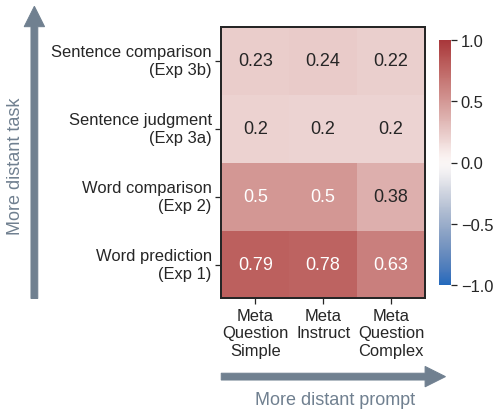

In [16]:
# Show heatmap of means.
m = np.zeros((len(task_order), len(META_EVAL_TYPES)))
for i, task in enumerate(task_order):
    task_data = ALL_CORRS[task]
    if task == "exp1":
        # average over corpora
        means = np.mean([
            task_data["p18"]["hf"], 
            task_data["p18"]["openai"],
            task_data["news"]["hf"],
            task_data["news"]["openai"]
        ], axis=0)
    elif task in ["exp3a", "exp3b"]:
        # average over corpora
        means = np.mean([
            task_data["syntaxgym"]["hf"], 
            task_data["syntaxgym"]["openai"],
            task_data["blimp"]["hf"],
            task_data["blimp"]["openai"]
        ], axis=0)
    else:
        # average over models
        means = np.mean([task_data["hf"], task_data["openai"]], axis=0)
    # get prompt-specific means (row-wise)
    m[i] = np.mean(means, axis=1)
    
ax = sns.heatmap(m, cbar_kws={"shrink": 0.9}, **HEATMAP_KWARGS)
ax.invert_yaxis() # put 0 on the bottom
ax.set_yticklabels([pretty_tasks[t] for t in task_order], rotation=0)
# ax.set_xticklabels(META_EVAL_TYPES, rotation=20, ha="right")
ax.set_xticklabels([m.replace("Meta", "Meta\n").replace("Question", "Question\n") for m in META_EVAL_TYPES]) #, rotation=20, ha="right")
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set(lw=2)
    
# Add annotations!
arrow_color = "slategrey"
arrow_kwargs = dict(head_width=0.3, head_length=0.3, width=0.1, fc=arrow_color, ec=arrow_color, clip_on=False)
plt.gcf().set_size_inches(5,5)
plt.arrow(-2.75, 0, 0, 4, **arrow_kwargs)
plt.arrow(0, -1.15, 3, 0, **arrow_kwargs)
plt.text(-3.15, 1, "More distant task", rotation=90, color=arrow_color)
plt.text(0.5, -1.55, "More distant prompt", color=arrow_color)

render("heatmap_avg.pdf")

## Figure 6 (appendix)

Rendered figure to heatmap_bymodel.pdf


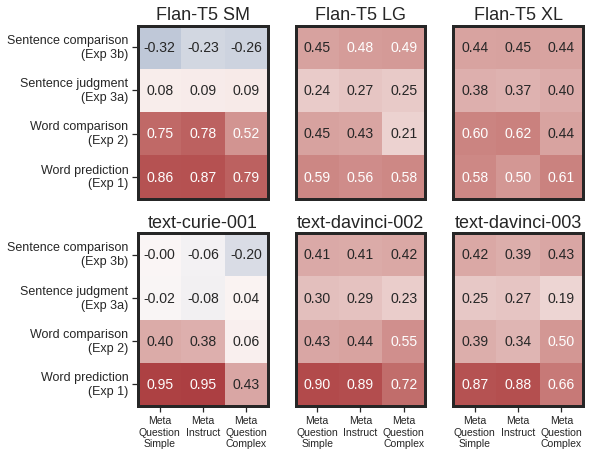

In [17]:
# Show by-model heatmap of means.
def plot_model_heatmap(m, model, ax=None, cbar=False):
    if ax is None:
        ax = plt.gca()
    ax = sns.heatmap(m, cbar=cbar, fmt=".2f", annot_kws={"size": 14}, ax=ax, **HEATMAP_KWARGS)
    ax.set_title(model)
    ax.invert_yaxis() # put 0 on the bottom
    ax.set_xticks([])
    ax.set_yticks([])
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set(lw=3)
    return ax

# Initialize subplots.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=((8,7)))

# HUGGINGFACE MODELS
for model_idx, model in enumerate(HF_MODELS):
    m = np.zeros((len(task_order), len(META_EVAL_TYPES)))
    for i, task in enumerate(task_order):
        task_data = ALL_CORRS[task]
        if task == "exp1":
            # average over corpora (model corresponds to column)
            m[i] = np.mean([
                task_data["p18"]["hf"][:,model_idx], 
                task_data["news"]["hf"][:,model_idx]
            ], axis=0)
        elif task in ["exp3a", "exp3b"]:
            # average over corpora (model corresponds to column)
            m[i] = np.mean([
                task_data["syntaxgym"]["hf"][:,model_idx], 
                task_data["blimp"]["hf"][:,model_idx]
            ], axis=0)
        else:
            m[i] = task_data["hf"][:,model_idx]

    ax = plot_model_heatmap(m, model, axes[0][model_idx])
    if model_idx == 0:
        ax.set_yticks([y+0.5 for y in range(len(pretty_tasks))])
        ax.set_yticklabels([pretty_tasks[t] for t in task_order], rotation=0, size="x-small")
    
# OPENAI MODELS
for model_idx, model in enumerate(OPENAI_MODELS):
    m = np.zeros((len(task_order), len(META_EVAL_TYPES)))
    for i, task in enumerate(task_order):
        task_data = ALL_CORRS[task]
        if task == "exp1":
            # average over corpora (model corresponds to column)
            m[i] = np.mean([
                task_data["p18"]["openai"][:,model_idx], 
                task_data["news"]["openai"][:,model_idx]
            ], axis=0)
        elif task in ["exp3a", "exp3b"]:
            # average over corpora (model corresponds to column)
            m[i] = np.mean([
                task_data["syntaxgym"]["openai"][:,model_idx], 
                task_data["blimp"]["openai"][:,model_idx]
            ], axis=0)
        else:
            m[i] = task_data["openai"][:,model_idx]

    ax = plot_model_heatmap(m, model, axes[1][model_idx]) #, cbar=(model_idx==2))
    if model_idx == 0:
        ax.set_yticks([y+0.5 for y in range(len(pretty_tasks))])
        ax.set_yticklabels([pretty_tasks[t] for t in task_order], rotation=0, size="x-small")
        
    ax.set_xticks([x+0.5 for x in range(len(META_EVAL_TYPES))])
    ax.set_xticklabels([
        m.replace("Meta", "Meta\n").replace("Question", "Question\n") for m in META_EVAL_TYPES
    ], size="xx-small")

render("heatmap_bymodel.pdf")